In [1]:
import numpy as np
from qore import Mine, ASP, QAOA, VQE
from qore.utils import measure_operator, get_bitstring_probabilities
from qore.algorithms.asp import construct_default_H_B
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit import Aer

In [2]:
penalty = 5.0
# qmine = Mine(np.array([[-2.0, 3.0, -1.0, -2.0, -1.0], [float('inf'), 1.0, -5.0, 10.0, float('inf')], [float('inf'), float('inf'), 4.0, float('inf'), float('inf')]]))
#qmine = Mine('mine_config.txt')
qmine = Mine('mine_config_large.txt')
 
qmine.plot_mine()

+---+--------+---------+--------+--------+---------+--------+---------+---------+---------+--------+
|   |   0    |    1    |   2    |   3    |    4    |   5    |    6    |    7    |    8    |   9    |
+---+--------+---------+--------+--------+---------+--------+---------+---------+---------+--------+
| 0 | -3.000 |  -1.000 | -2.000 | -1.000 | -18.000 | -3.000 |  -5.000 |  -5.000 |  -7.000 | -9.000 |
| 1 |  inf   | -10.000 | -8.000 | -6.000 |  -5.000 | -2.000 | -10.000 |  17.000 | -28.000 |  inf   |
| 2 |  inf   |   inf   | 8.000  | -1.000 |  8.000  | 6.000  |  9.000  | -32.000 |   inf   |  inf   |
| 3 |  inf   |   inf   |  inf   | -3.000 |  6.000  | 13.000 |  22.000 |   inf   |   inf   |  inf   |
| 4 |  inf   |   inf   |  inf   |  inf   |  48.000 | 10.000 |   inf   |   inf   |   inf   |  inf   |
+---+--------+---------+--------+--------+---------+--------+---------+---------+---------+--------+


In [3]:
H = qmine.gen_Hamiltonian(penalty=penalty)

In [10]:
aqua_globals.random_seed = 1953
backend = Aer.get_backend('statevector_simulator')
instance = QuantumInstance(backend=backend)

In [11]:
def analysis(circuit):
    x = get_bitstring_probabilities(circuit, instance, shots=1024)
    # x_sorted = sorted(x.items(), key=lambda item: item[1])
    # for i in range(5):
    #     print("The most probable configurations and the corresponding probabilities:")
    #     print(f"{x_sorted[i][0]}, {x_sorted[i][1]}")
    bitstr, prob = max(x.items(), key=lambda item: item[1])
    print(f"The most probable configuration and the corresponding probability: {bitstr, prob}")
    print("------------------------------------------------------------")


In [12]:
evol_time = 20
nsteps = 100

circuit = ASP(H, 
    evol_time=evol_time, 
    nsteps=nsteps, 
    callback=analysis,
    callback_freq=40,
    quantum_instance=instance).construct_circuit()
    

#analysis(circuit)

The most probable configuration and the corresponding probability: ('101101000', 0.0078125)
------------------------------------------------------------
The most probable configuration and the corresponding probability: ('010011110', 0.2451171875)
------------------------------------------------------------
The most probable configuration and the corresponding probability: ('010011110', 0.9638671875)
------------------------------------------------------------


In [13]:
s = '010011110'
qmine.plot_mine_state(s)

+---+---+---+---+---+---+
|   | 0 | 1 | 2 | 3 | 4 |
+---+---+---+---+---+---+
| 0 | 0 | 1 | 1 | 1 | 1 |
| 1 | x | 0 | 0 | 1 | x |
| 2 | x | x | 0 | x | x |
+---+---+---+---+---+---+


In [14]:
fs = ''.join(list(s)[::-1])
qmine.plot_mine_state(fs)

+---+---+---+---+---+---+
|   | 0 | 1 | 2 | 3 | 4 |
+---+---+---+---+---+---+
| 0 | 0 | 1 | 0 | 0 | 1 |
| 1 | x | 1 | 1 | 1 | x |
| 2 | x | x | 0 | x | x |
+---+---+---+---+---+---+


## Benchmark with pseudoflow

In [4]:
import networkx as nx
from networkx import Graph
import matplotlib.pyplot as plt
import pseudoflow

In [5]:
graph, source, sink = qmine.build_pseudoflow_graph()

In [6]:
from qore.algorithms.pseudoflow import Pseudoflow

In [7]:
pf = Pseudoflow(graph, source, sink)

In [10]:
res = pf.run()

In [11]:
qmine.plot_mine_state(res['ground_state'])

+---+---+---+---+---+---+---+---+---+---+---+
|   | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
+---+---+---+---+---+---+---+---+---+---+---+
| 0 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 0 |
| 1 | x | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 0 | x |
| 2 | x | x | 1 | 1 | 1 | 1 | 1 | 0 | x | x |
| 3 | x | x | x | 1 | 1 | 1 | 0 | x | x | x |
| 4 | x | x | x | x | 1 | 0 | x | x | x | x |
+---+---+---+---+---+---+---+---+---+---+---+


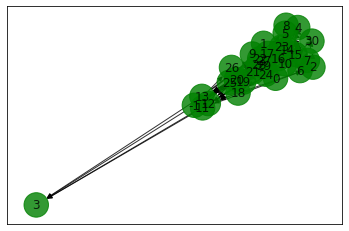

In [5]:
# plot the pseudoflow graph
colors = ['g' for node in graph.nodes()]
pos = nx.spring_layout(graph)

default_axes = plt.axes(frameon=True)
nx.draw_networkx(graph, node_color=colors, node_size=600,
                    alpha=.8, ax=default_axes, pos=pos)